In [21]:
import numpy as np
import os
import onnxruntime as ort
import tqdm
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
model_path = '../weights/ddcolor-tiny-op12.onnx'    # python export.py --model_path pretrain/ddcolor_paper_tiny.pth --export_path weights/ddcolor-tiny-op12.onnx

#Load some example image
img = cv2.imread('../assets/test_images/Audrey Hepburn.jpg', cv2.IMREAD_COLOR)

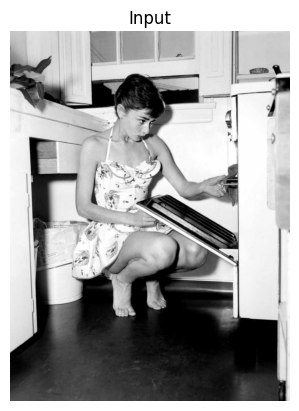

In [22]:
plt.imshow(img)
plt.title('Input') 
plt.axis('off');

In [23]:
tmp_ort_session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

# print the input,output names and shapes
for i in range(len(tmp_ort_session.get_inputs())):
    print(f"Input name: {tmp_ort_session.get_inputs()[i].name}, shape: {tmp_ort_session.get_inputs()[i].shape}")
for i in range(len(tmp_ort_session.get_outputs())):
    print(f"Output name: {tmp_ort_session.get_outputs()[i].name}, shape: {tmp_ort_session.get_outputs()[i].shape}")


providers = [
    # The TensorrtExecutionProvider is the fastest.
    ('TensorrtExecutionProvider', { 
        'device_id': 0,
        'trt_max_workspace_size': 4 * 1024 * 1024 * 1024,
        'trt_fp16_enable': True,
        'trt_engine_cache_enable': True,
        'trt_engine_cache_path': './trt_engine_cache',
        'trt_engine_cache_prefix': 'model',
        'trt_dump_subgraphs': False,
        'trt_timing_cache_enable': True,
        'trt_timing_cache_path': './trt_engine_cache',
        #'trt_builder_optimization_level': 3,
    }),

    # The CUDAExecutionProvider is slower than PyTorch, 
    # possibly due to performance issues with large matrix multiplication "cossim = torch.bmm(feats1, feats2.permute(0,2,1))"
    # Reducing the top_k value when exporting to ONNX can decrease the matrix size.
    ('CUDAExecutionProvider', { 
        'device_id': 0,
        'gpu_mem_limit': 4 * 1024 * 1024 * 1024,
    }),
    ('CPUExecutionProvider',{ 
    })
]

ort_session = ort.InferenceSession(model_path, providers=providers)

Input name: input, shape: [1, 3, 512, 512]
Output name: output, shape: [1, 2, 512, 512]


## Prepare input tensor

In [24]:
input_size = 512
batch_size = 1
height, width = img.shape[:2]
# print(self.width, self.height)
# if self.width * self.height < 100000:
#     self.input_size = 256

img = (img / 255.0).astype(np.float32)
orig_l = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, :1]  # (h, w, 1)

# resize rgb image -> lab -> get grey -> rgb
img_resize = cv2.resize(img, (input_size, input_size))
img_l = cv2.cvtColor(img_resize, cv2.COLOR_BGR2Lab)[:, :, :1]
img_gray_lab = np.concatenate((img_l, np.zeros_like(img_l), np.zeros_like(img_l)), axis=-1)
img_gray_rgb = cv2.cvtColor(img_gray_lab, cv2.COLOR_LAB2RGB)

img_gray_rgb = img_gray_rgb.transpose((2, 0, 1)).astype(np.float32)
img_gray_rgb = np.expand_dims(img_gray_rgb, axis=0)

# Psuedo-batch the input images
img_gray_rgb = np.concatenate([img_gray_rgb for _ in range(batch_size)], axis=0)

inputs = {
    ort_session.get_inputs()[0].name: img_gray_rgb,
}

# output_ab = self.model(tensor_gray_rgb).cpu()  # (1, 2, self.height, self.width)

## Process output 

In [25]:
output_ab = torch.from_numpy(ort_session.run(None, inputs)[0])

output_ab_resize = F.interpolate(output_ab, size=(height, width))[0].float().numpy().transpose(1, 2, 0)
output_lab = np.concatenate((orig_l, output_ab_resize), axis=-1)
output_rgb = cv2.cvtColor(output_lab, cv2.COLOR_LAB2RGB)

output_img = (output_rgb * 255.0).round().astype(np.uint8)  

## Output visualization

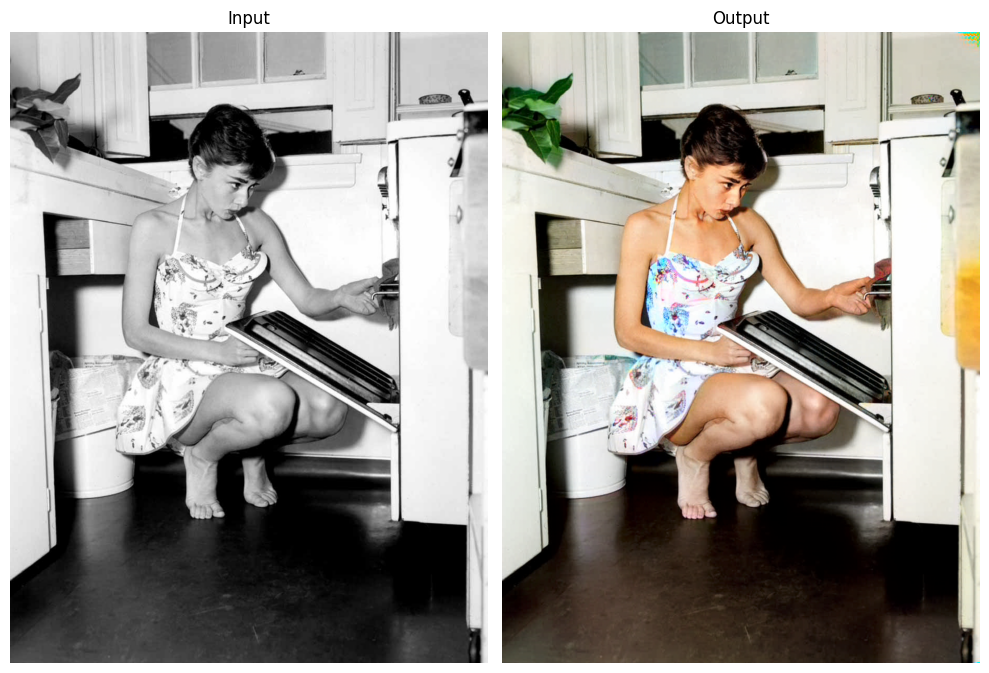

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Display input image in the first subplot
axs[0].imshow(img)
axs[0].set_title('Input')  # Set title for the input image
axs[0].axis('off')  # Disable axis

# Display output image in the second subplot
axs[1].imshow(output_img)
axs[1].set_title('Output')  # Set title for the output image
axs[1].axis('off')  # Disable axis

# Show the images
plt.tight_layout()
plt.show();

## Benchmark

In [27]:
import time

# Run the model 100 times to get an average time
times = []
for i in tqdm.tqdm(range(100)):
    start = time.time()
    outputs = ort_session.run(None, inputs)
    times.append(time.time() - start)

print(f"Average time per batch: {np.mean(times):.4f} seconds")
print(f"Average time per image: {np.mean(times)/batch_size:.4f} seconds")
print(f"Average FPS per image: {batch_size/np.mean(times):.4f}")

100%|██████████| 100/100 [00:56<00:00,  1.75it/s]

Average time per batch: 0.5690 seconds
Average time per image: 0.5690 seconds
Average FPS per image: 1.7575
